# YouTube Launch Performance Automation using CNN
Define, design and experimented models for YouTube launch performance automation testing

In [1]:
train_image_path = '/Users/peli/Google Drive/CS231n/Thumbnails'
labels = ['Logo','TextLoaded','ImageLoaded','SpinLoading','WhiteScreen']

### Load one image, and a label

In [2]:
from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
filename = '12_05_2017_13_52_50_0101.thumbnail.jpg'
im = Image.open(join(train_image_path, 'Logo', filename))
img_data = np.asarray(im)
Width, Height = img_data.shape
print(img_data.shape)
img_data_reshaped = img_data.flatten()
print(img_data_reshaped.shape)
label = np.zeros(len(labels))
label[labels.index('Logo')] = 1
print(label)

(72, 128)
(9216,)
[ 1.  0.  0.  0.  0.]


### Load all data

In [3]:
import os

images_data = [] 
labels_data = []
test_imgs = []
test_labels = []
for i, l in enumerate(labels):
    img_folder = join(train_image_path, l)
    img_files  = [f for f in listdir(img_folder) if isfile(join(img_folder, f)) and os.path.splitext(f)[1]=='.jpg']
    count = len(img_files)
    for k, img_file in enumerate(img_files):
        im = Image.open(join(img_folder, img_file))
        img_data = np.asarray(im)
        label = np.zeros(len(labels))
        label[i] = 1
        if count-k < 100:
            test_imgs.append(img_data.flatten())
            test_labels.append(label)
        else:
            labels_data.append(label)
            images_data.append(img_data.flatten())
            #if len(images_data) in [1534, 1543, 1540]:
            #    print(join(img_folder, img_file))
    assert(len(images_data)==len(labels_data))
print(len(images_data))
print(len(labels_data))
print(labels_data[-1])
print(images_data[-1])

4152
4152
[ 0.  0.  0.  0.  1.]
[255 255 255 ..., 255 255 255]


### show some images to check the data

Test Images Shape:(495, 9216)
Train Images Shape:(4152, 9216)


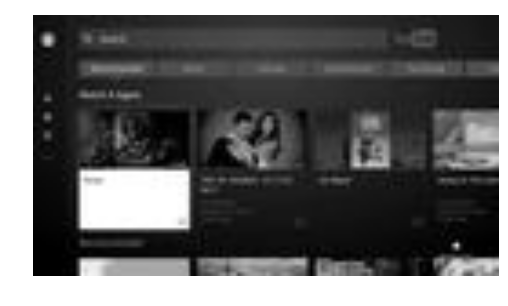

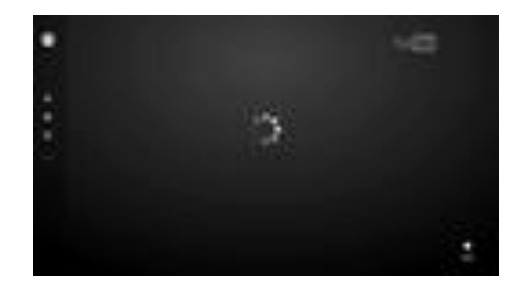

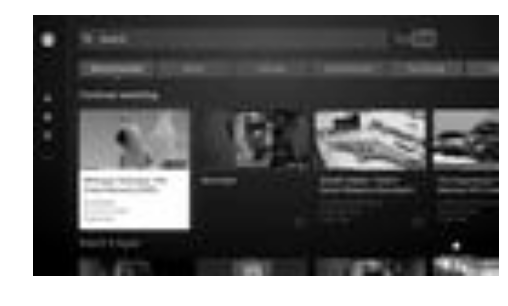

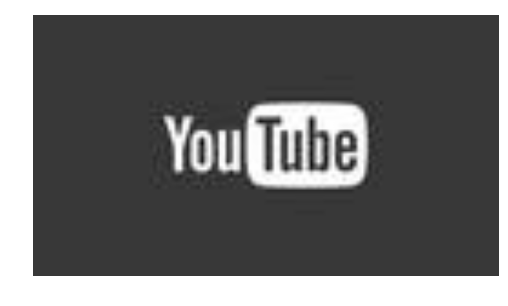

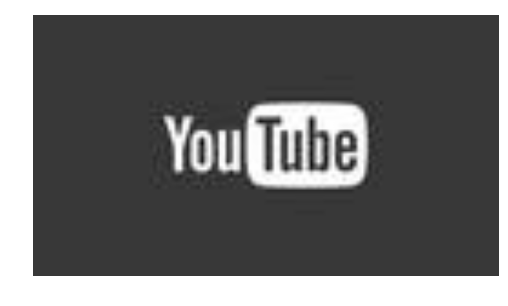

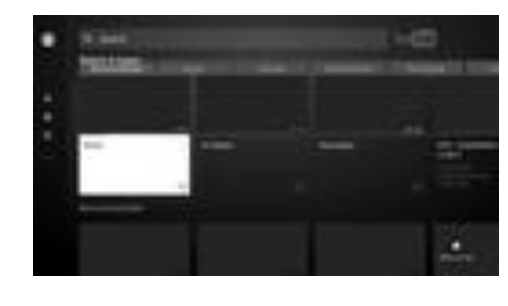

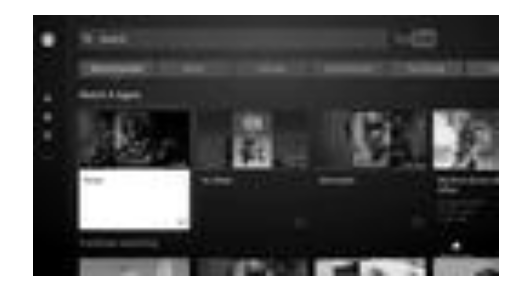

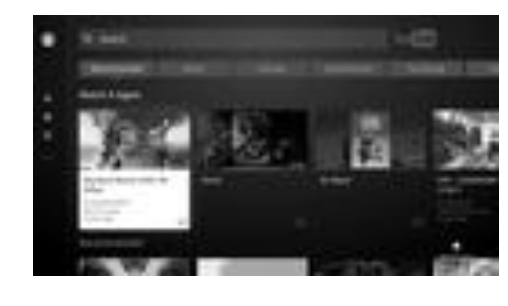

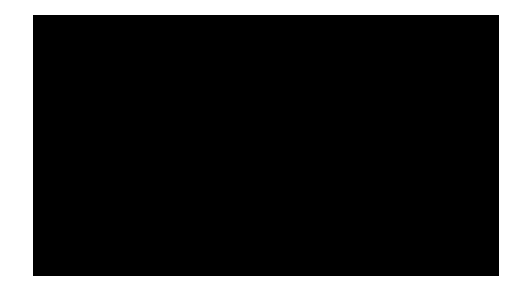

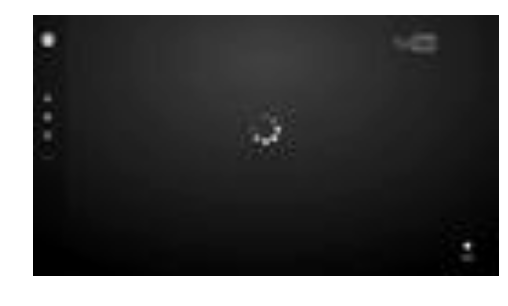

In [4]:
import matplotlib.pyplot as plt
images_np = np.asarray(images_data)
labels_np = np.asarray(labels_data)
test_images_np = np.asarray(test_imgs)
test_labels_np = np.asarray(test_labels)
print('Test Images Shape:{}'.format(test_images_np.shape))
print('Train Images Shape:{}'.format(images_np.shape))
def show_image(image):
    plt.axis('off')
    plt.imshow(image.reshape(Width, Height), cmap = plt.get_cmap('gray'))
    plt.show()
    
N = len(images_data)
random_image_indices = np.random.randint(0,N,10)

for i in random_image_indices:
    show_image(images_np[i])

### Define batch function

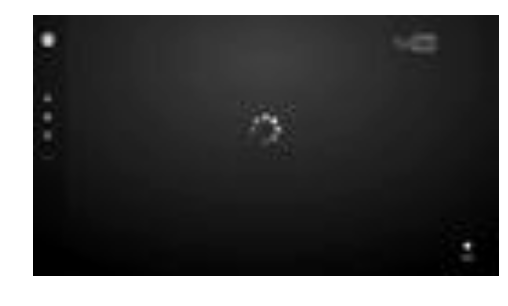

(100, 9216) (100, 5)


In [5]:
def next_batch(num=100):
    indices = np.random.randint(0,N,100)
    return images_np[indices], labels_np[indices]

imgs, lbs = next_batch() 
show_image(imgs[10])
print(imgs.shape, lbs.shape)

In [6]:
print('Image Width {} Height {}'.format(Width, Height))
#logs_path = '/tmp/tensorflow_logs/YouTube'

Image Width 72 Height 128


### Linear regression use Tensorflow with softmax loss function

In [7]:
import tensorflow as tf
import timeit
#model_path = '/tmp/softmax.ckpt'
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, Width*Height]) #mnist.train.images[i]
y_ = tf.placeholder(tf.float32, shape=[None, 5])   #mnist.train.labels[i]
W = tf.Variable(tf.zeros([Width*Height, 5])) # W init, to-do:better with random
b = tf.Variable(tf.zeros([5]))     # b init.   
#saver = tf.train.Saver() #'Saver' op to save and restore all the variables

In [8]:
y = tf.matmul(x, W) + b
with tf.name_scope('Loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)) # loss function
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

tf.summary.scalar("loss", cross_entropy)
merged_summary_op = tf.summary.merge_all()

### Training linear regression model

In [10]:
#summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(100):
        batch = next_batch(100) #batch size 100
        _, cost = sess.run([train_step, cross_entropy], feed_dict={x:batch[0], y_:batch[1]})
        costs.append(cost)
    start_time = timeit.default_timer()
    # code you want to evaluate
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc = accuracy.eval(feed_dict={x:test_images_np, y_:test_labels_np})
    elapsed = timeit.default_timer() - start_time
    #save_path = saver.save(sess, model_path)
#print('saved to {}'.format(save_path))
print(acc, elapsed)

1.0 0.03936134099967603


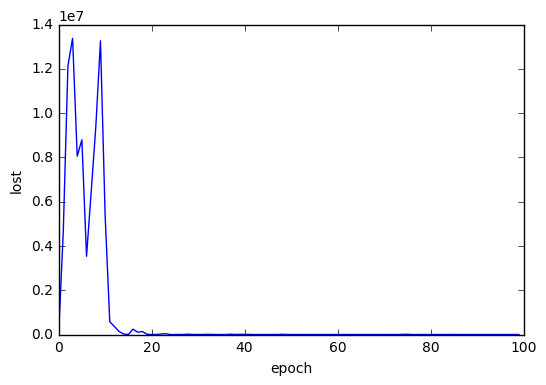

In [11]:
plt.plot(costs)
plt.ylabel('lost')
plt.xlabel('epoch')
plt.show()

### Test load saved model and test

In [12]:
'''
print('Restore variables from do validate')
tf.reset_default_graph()
model_path = '/tmp/softmax.ckpt'
x = tf.placeholder(tf.float32, shape=[None, Width*Height])
y_ = tf.placeholder(tf.float32, shape=[None, 5])   
W = tf.Variable(tf.zeros([Width*Height, 5])) # W init
b = tf.Variable(tf.zeros([5]))     # b init.   
y = tf.matmul(x, W) + b
saver = tf.train.Saver() 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path)
    start_time = timeit.default_timer()
    # code you want to evaluate
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc = accuracy.eval(feed_dict={x:test_images_np, y_:test_labels_np})
    elapsed = timeit.default_timer() - start_time
print('Accuracy {:.2f}, elapsed time {:.3f}'.format(acc, elapsed))
'''

"\nprint('Restore variables from do validate')\ntf.reset_default_graph()\nmodel_path = '/tmp/softmax.ckpt'\nx = tf.placeholder(tf.float32, shape=[None, Width*Height])\ny_ = tf.placeholder(tf.float32, shape=[None, 5])   \nW = tf.Variable(tf.zeros([Width*Height, 5])) # W init\nb = tf.Variable(tf.zeros([5]))     # b init.   \ny = tf.matmul(x, W) + b\nsaver = tf.train.Saver() \nwith tf.Session() as sess:\n    sess.run(tf.global_variables_initializer())\n    saver.restore(sess, model_path)\n    start_time = timeit.default_timer()\n    # code you want to evaluate\n    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))\n    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))\n    acc = accuracy.eval(feed_dict={x:test_images_np, y_:test_labels_np})\n    elapsed = timeit.default_timer() - start_time\nprint('Accuracy {:.2f}, elapsed time {:.3f}'.format(acc, elapsed))\n"

### k-NN Model

In [12]:
#k-NN
tf.reset_default_graph()
x_train = tf.placeholder(tf.float32, shape=[None, Width*Height])
x_test  = tf.placeholder(tf.float32, shape=[Width*Height])
distance = tf.reduce_sum(tf.abs(tf.add(x_train, tf.negative(x_test))), reduction_indices=1)
predict = tf.arg_min(distance, 0)

accuracy = 0.0
test_counts = len(test_images_np)
indices = np.random.randint(0, len(test_images_np), test_counts)
incorrect = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    correct_count = 0
    start_time = timeit.default_timer()
    for i in range(len(test_images_np)): #indices:#
        nn_index = sess.run(predict, feed_dict={x_train:images_np, x_test:test_images_np[i, :]})
        if np.argmax(labels_np[nn_index]) == np.argmax(test_labels_np[i]):
            correct_count += 1
        else:
            incorrect.append((nn_index, i))
    elapsed = timeit.default_timer() - start_time
print('Accuracy {:.02f} Elapsed {:.02f}'.format(correct_count/test_counts, elapsed))

Accuracy 1.00 Elapsed 142.58


In [13]:
#print out the incorrect labels in pair
for i,j in incorrect:
    print(i,j)

[ 0.  0.  1.  0.  0.]


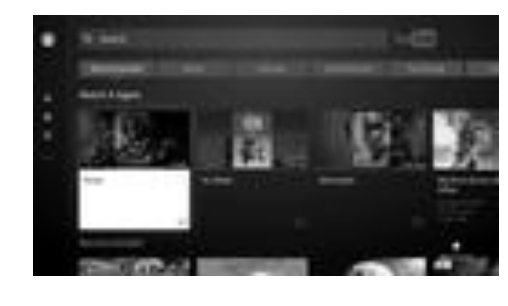

[ 0.  0.  1.  0.  0.]


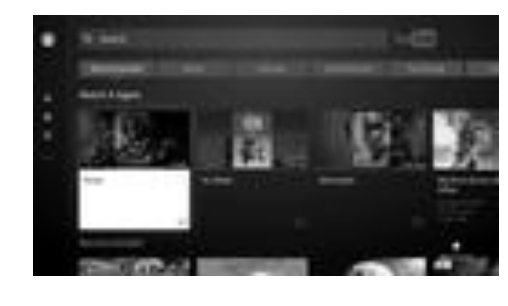

[ 0.  0.  1.  0.  0.]


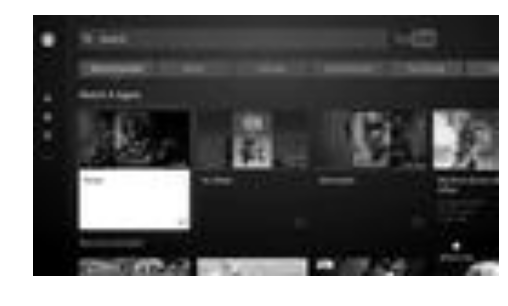

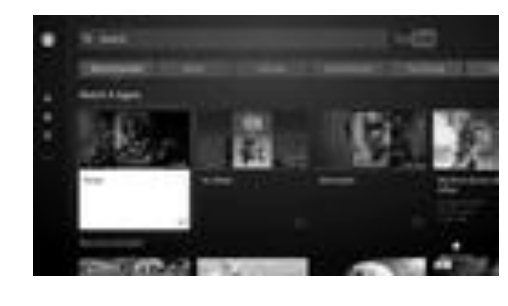

In [14]:
''' Below images are miss labeled!
12_05_2017_12_00_12_0501.thumbnail.jpg
12_05_2017_12_52_39_0501.thumbnail.jpg
12_05_2017_12_54_26_0501.thumbnail.jpg
12_05_2017_12_55_20_0501.thumbnail.jpg
12_05_2017_12_55_38_0501.thumbnail.jpg
'''

print(labels_np[1534])
show_image(images_np[1535])
print(labels_np[1535])
show_image(images_np[1536])
print(labels_np[1536])
show_image(images_np[1540])
show_image(images_np[1541])


In [15]:
print(images_np.shape)

(4152, 9216)


In [16]:
print(test_images_np.shape)

(495, 9216)


### Support Vector Machine Model

In [17]:
from sklearn import svm
X = images_np
Y = [np.argmax(t) for t in labels_np]
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
start_time = timeit.default_timer()
ys = clf.predict(test_images_np)
elapsed = timeit.default_timer() - start_time
correct_count = 0
for i, c in enumerate(ys):
    if c==np.argmax(test_labels_np[i]):
        correct_count += 1
print('Accuracy:{:.2f}, Elapsed:{:.3f}'.format(correct_count/len(test_labels_np), elapsed))

Accuracy:0.89, Elapsed:3.433


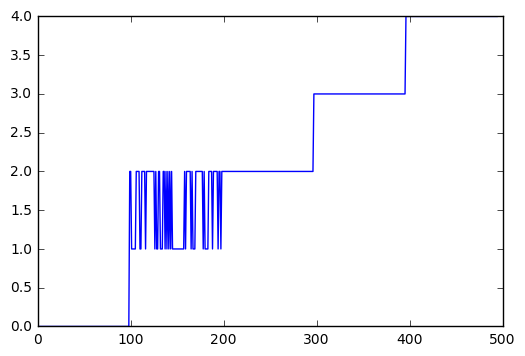

In [19]:
plt.plot(ys)
plt.show()

### k-means clustering

In [18]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_digits = 5
data = images_np
print(data.shape)
pca = PCA(n_components=n_digits).fit(data)
estimator = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
estimator.fit(data)
print(estimator.labels_.shape)

(4152, 9216)
(4152,)


In [19]:
estimator.labels_[1]

0

In [20]:
import sys
def most_over_half(nums): #Bayer-Moore vote
    result = sys.maxsize 
    cnt = 0
    for n in nums:
        if result==n:
            cnt += 1
        else:
            if cnt==0:
                result=n
            else:
                cnt -= 1
    return result
test_nums = [5,7,8,9,5,2,5,5,5,5,7]
print(most_over_half(test_nums)) #should be 5

5


In [21]:
print(labels_np.shape)
indices = []
i_start, i_end = 0, 0
v = np.argmax(labels_np[0])
print(v)
for i, val in enumerate(labels_np):
    if v != np.argmax(val):
        indices.append((i_start, i))
        print(indices[-1])
        i_start = i
        v = np.argmax(val)
indices.append((i_start, len(labels_np)))
print(indices[-1])

for s,e in indices:
    print(most_over_half(estimator.labels_[s:e]))

(4152, 5)
0
(0, 996)
(996, 1190)
(1190, 2160)
(2160, 3157)
(3157, 4152)
0
1
1
3
2


### Balanced training data for k-means cluster

In [24]:
min_len = np.min([e-s for s,e in indices])
print(min_len)
print(data.shape)
balanced_data = np.empty([0,data.shape[-1]])
print(balanced_data.shape)
for s,_ in indices:
    balanced_data = np.vstack((balanced_data, data[s:s+min_len]))
    #show_image(data[s])
print(balanced_data.shape)


194
(4152, 9216)
(0, 9216)
(970, 9216)


In [25]:
balanced_pca = PCA(n_components=n_digits).fit(balanced_data)
b_estimator = KMeans(init=balanced_pca.components_, n_clusters=n_digits, n_init=1)
b_estimator.fit(balanced_data)
print(b_estimator.labels_.shape)

(970,)


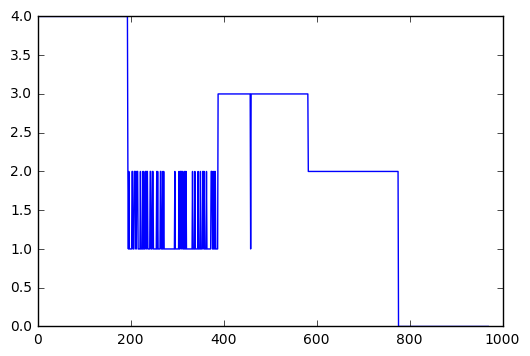

In [26]:
plt.plot(b_estimator.labels_)
plt.show()

In [27]:
# get right kmean_labels
total_correct_count = 0
kmean_labels = []
for i in range(5):
    correct_label = most_over_half(b_estimator.labels_[i*min_len:(i+1)*min_len])
    kmean_labels.append(correct_label)
    #correct_count = b_estimator.labels_[i*min_len:(i+1)*min_len]
    unique, counts = np.unique(b_estimator.labels_[i*min_len:(i+1)*min_len], return_counts=True)
    correct_count = dict(zip(unique, counts))[correct_label]
    print(correct_count)
    total_correct_count += correct_count
print('Training Accuracy is {:.2f}'.format(total_correct_count/(5*min_len)))

194
144
193
194
194
Training Accuracy is 0.95


/Users/peli/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


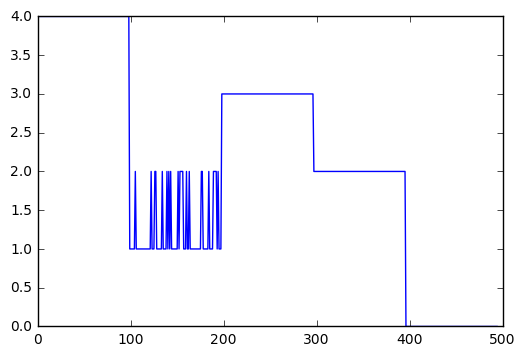

[4, 1, 3, 2, 0]
Test Accuracy is 0.92, Elpased 0.02


In [28]:
#predict on test data
start_time = timeit.default_timer()
predicts = b_estimator.predict(test_images_np)
elapsed = timeit.default_timer() - start_time
plt.plot(predicts)
plt.show()
total_correct_count = 0
print(kmean_labels)
for i in range(5):
    unique, counts = np.unique(predicts[i*100:(i+1)*100], return_counts=True)
    correct_count = dict(zip(unique, counts))[kmean_labels[i]]
    total_correct_count += correct_count
print('Test Accuracy is {:.2f}, Elpased {:.2f}'.format(total_correct_count/500, elapsed))

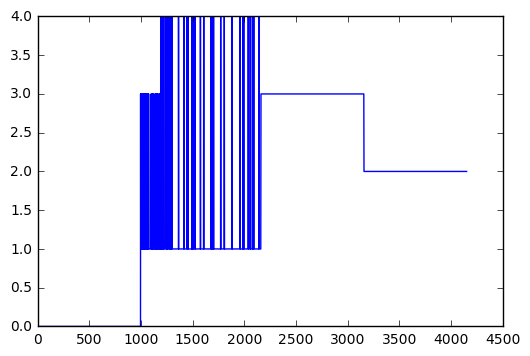

In [29]:
plt.plot(estimator.labels_)
plt.show()

### Simple CNN Network

In [13]:
tf.reset_default_graph()
x_cnn = tf.placeholder(tf.float32, shape=[None, Width*Height*1])
y_cnn = tf.placeholder(tf.int64, shape=[None, 5])

In [14]:
is_training = tf.placeholder(tf.bool)

# define model
def simple_cnn(X,y,is_training):
    cnn_layer = tf.layers.conv2d(inputs=tf.reshape(X,[tf.shape(X)[0], Width, Height, 1]), \
                                 kernel_size=[4, 4], filters=1, activation=tf.nn.relu)
    flt = tf.contrib.layers.flatten(cnn_layer)
    y_out = tf.layers.dense(inputs=flt, units=5)
    return y_out

y_trained = simple_cnn(x_cnn,y_cnn,is_training)
# define our loss
total_loss = tf.losses.hinge_loss(labels=y_cnn,\
                                  logits=y_trained)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

In [15]:
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(500):
        batch = next_batch(100) #batch size 100
        _, cost = sess.run([train_step, mean_loss], feed_dict={x_cnn:batch[0], y_cnn:batch[1]})
        costs.append(cost)
    start_time = timeit.default_timer()
    # code you want to evaluate
    correct_prediction = tf.equal(tf.argmax(y_trained, 1), tf.argmax(y_cnn, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc = accuracy.eval(feed_dict={x_cnn:test_images_np, y_cnn:test_labels_np})
    elapsed = timeit.default_timer() - start_time
#print('saved to {}'.format(save_path))
print('Simple CNN - Accuracy {:.2f}, elapsed time {:.3f}'.format(acc, elapsed))

Simple CNN - Accuracy 1.00, elapsed time 0.473


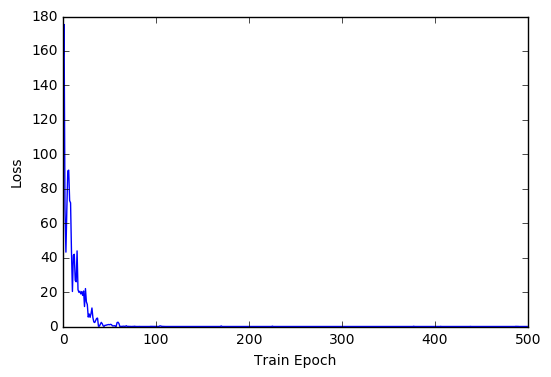

In [17]:
plt.plot(costs)
plt.ylabel('Loss')
plt.xlabel('Train Epoch')
plt.show()